# Lecture 12. 신경망: 학습 구현 (다중 분류)

> Eunmi Kim    
 계산과학 프로그래밍 및 실습


---


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

## 1. Layer 구현


### 1.1 ReLU

In [ ]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

### 1.2 Sigmoid

In [ ]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out

        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx

### 1.3 Affine

In [ ]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b

        self.x = None

        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx

### 1.4 Itentity

Activation function을 사용하지 않는 경우를 Itentiy function으로 구현함.


In [ ]:
class Identity:
    def __init__(self):
        pass

    def forward(self, x):
        return x

    def backward(self, dout):
        return dout

### 1.5 Softmax with Cross Entropy Loss

In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

In [ ]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    num_data = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / num_data

In [ ]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        num_data = self.t.shape[0]
        dx = (self.y - self.t) / num_data

        return dx

## 2. 다중 분류

### 2.1 Data

from Stanford CS231n

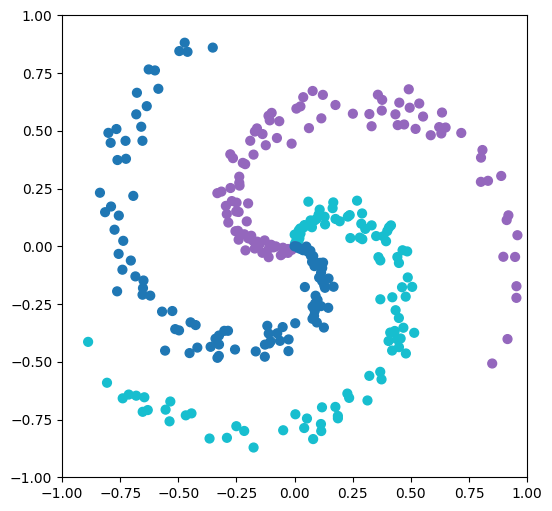

In [ ]:
# data generation
np.random.seed(0)
N = 100 # number of points per class -> 클래스 당 데이터 100개
D = 2   # dimensionality -> 각 데이터는 [x1, x2] 이런 식으로 되어있음
K = 3   # number of classes -> 클래스 개수
X = np.zeros((N*K,D)) #300*2 matrix 생성 (데이터 담는 matrix)
y = np.zeros(N*K, dtype='uint8') #예측치?들어갈 거같음...

for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0, 1, N) # radius
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.column_stack((r*np.sin(t), r*np.cos(t)))
    y[ix] = j
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.tab10_r)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

In [ ]:
print(X)
print(y)

In [ ]:
print(X.shape)
print(X[:3, :])

(300, 2)
[[0.         0.        ]
 [0.00121358 0.01002784]
 [0.00551604 0.01943438]]


In [ ]:
print(y.shape)
print(y[1], y[101], y[201], sep='\t')

(300,)
0	1	2


In [ ]:
# Data preprocessing (one-hot encoding)
x_train = X #위에서 가져온 데이터
y_train = np.eye(K)[y]
print(x_train.shape, y_train.shape)

(300, 2) (300, 3)


In [ ]:
np.eye(3)[[1, 1, 2, 0]]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

### 2.2 One Layer Net

In [ ]:
class OneLayerNet:

    def __init__(self, input_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, output_size)
        self.params['b1'] = np.zeros(output_size)


        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])

        self.lastLayer = SoftmaxWithLoss()


    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)


    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1: t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy


    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db

        return grads

In [ ]:
# model
input_size = x_train.shape[-1]
output_size = y_train.shape[-1]

network = OneLayerNet(input_size=input_size, output_size=output_size)

# hyperparameters
iters_num = 200
learning_rate = 0.1


# training
train_loss_list = []
train_acc_list = []


for i in range(iters_num):

    loss = network.loss(x_train, y_train)
    train_loss_list.append(loss)

    train_acc = network.accuracy(x_train, y_train)
    train_acc_list.append(train_acc)

    if (i+1) % 10 == 0:
        print("iteration %4d: loss %.4f,  accuracy %.4f" % (i+1, loss, train_acc))

    # 기울기 계산 (오차역전파법)
    grad = network.gradient(x_train, y_train)

    # weight update
    for key in network.params:
        network.params[key] -= learning_rate * grad[key]

In [ ]:
# plot loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list)
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(train_acc_list)
plt.title('Accuracy')
plt.show()

In [ ]:
# prediction
print(network.predict([[1 ,1],[-.5, .5]]))

y_pred = softmax(network.predict([[1, 1],[-.5, .5]]))
print(y_pred)

In [ ]:
# plot the resulting classifier
xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 100), np.linspace(-1.1, 1.1, 100))
Z = network.predict(np.column_stack((xx.flatten(), yy.flatten())))
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.tab10_r)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()

### 2.3 Two Layer Net

In [ ]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()


    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)


    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy


    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [ ]:
# model
input_size = x_train.shape[-1]
output_size = y_train.shape[-1]
hidden_size = 100

network = TwoLayerNet(input_size=input_size, hidden_size=hidden_size, output_size=output_size)


# hyperparameters
iters_num = 5000
learning_rate = 0.3


# training
train_loss_list = []
train_acc_list = []


for i in range(iters_num):

    loss = network.loss(x_train, y_train)
    train_loss_list.append(loss)

    train_acc = network.accuracy(x_train, y_train)
    train_acc_list.append(train_acc)

    if (i+1) % 500 == 0:
        print("iteration %5d: loss %.4f,  accuracy %.4f" % (i+1, loss, train_acc))

    # 기울기 계산 (오차역전파법)
    grad = network.gradient(x_train, y_train)

    # weight update
    for key in network.params:
        network.params[key] -= learning_rate * grad[key]

iteration   500: loss 0.6863,  accuracy 0.5900
iteration  1000: loss 0.4110,  accuracy 0.7767
iteration  1500: loss 0.2593,  accuracy 0.8900
iteration  2000: loss 0.1955,  accuracy 0.9233
iteration  2500: loss 0.1532,  accuracy 0.9500
iteration  3000: loss 0.1238,  accuracy 0.9567
iteration  3500: loss 0.1035,  accuracy 0.9700
iteration  4000: loss 0.0874,  accuracy 0.9733
iteration  4500: loss 0.0753,  accuracy 0.9733
iteration  5000: loss 0.0662,  accuracy 0.9833


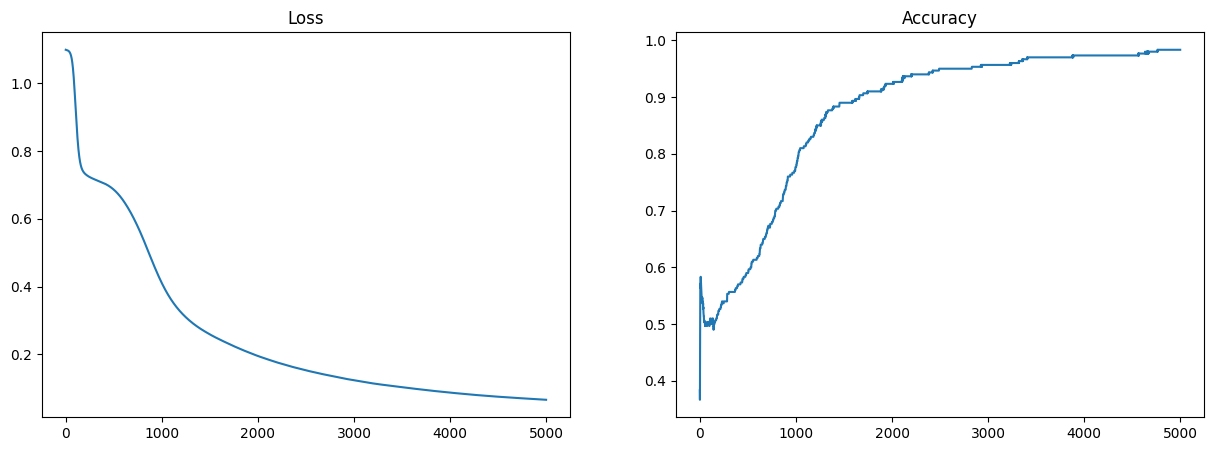

In [ ]:
# plot loss and accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list)
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(train_acc_list)
plt.title('Accuracy')
plt.show()

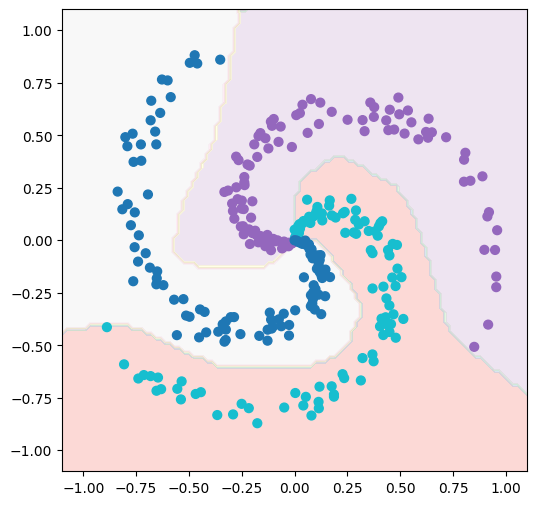

In [ ]:
# plot the resulting classifier
xx, yy = np.meshgrid(np.linspace(-1.1, 1.1, 100), np.linspace(-1.1, 1.1, 100))
Z = network.predict(np.column_stack((xx.flatten(), yy.flatten())))
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1, alpha=0.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.tab10_r)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.show()